# Predicting whether a mammogram mass is benign or malignant

Source data: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)

This data contains 961 instances of masses detected in mammograms, and contains the following attributes:

   1. BI-RADS assessment: 1 to 5 (ordinal)  
   2. Age: patient's age in years (integer)
   3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
   4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
   5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
   6. Severity: benign=0 or malignant=1 (binominal)
   
BI-RADS is an assesment of how confident the severity classification is; it is not a "predictive" attribute and so we will discard it. The age, shape, margin, and density attributes are the features that we will build our model with, and "severity" is the classification we will attempt to predict based on those attributes.

A lot of unnecessary anguish and surgery arises from false positives arising from mammogram results. If we can build a better way to interpret them through supervised machine learning, it could improve a lot of lives.


## Import required libraries

In [21]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt

## Prepare data

In [2]:
headers = ["BI_RADS", "age", "shape", "margin", "density", "severity"]
data = pd.read_csv("mammographic_masses.data.txt", names=headers, na_values="?")
data.dropna(inplace=True)
data.head()

,BI_RADS,age,shape,margin,density,severity
0,5.0,67.0,3.0,5.0,3.0,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
8,5.0,57.0,1.0,5.0,3.0,1
10,5.0,76.0,1.0,4.0,3.0,1


In [3]:
features = data[["age", "shape", "margin", "density"]].to_numpy(copy=True)
target = data["severity"].to_numpy(copy=True)
feature_names = data[["age", "shape", "margin", "density"]].columns.to_numpy(copy=True)

Some of our models require the input data to be normalized.

In [4]:
scaler = StandardScaler()
transformed_features = scaler.fit_transform(features)

We also need to be able to validate our results.

In [5]:
x_train, x_test, y_train, y_test = train_test_split(transformed_features, target, train_size=0.75)

Create a dictionary in which to store the models that we are creating.

In [6]:
models = {}

## Decision Tree / Random Forest

In [8]:
DecisionTreeClassifier = tree.DecisionTreeClassifier().fit(x_train, y_train)
models["DecisionTree"] = DecisionTreeClassifier

In [9]:
RandomForest = RandomForestClassifier(n_estimators=10).fit(x_train, y_train)
models['RandomForest'] = RandomForest

## SVM

In [10]:
C = 1.0
svc_kernels = ["linear", "rbf", "sigmoid", "poly"]
for kernel in svc_kernels:
    svc_model = svm.SVC(kernel=kernel, C=C).fit(x_train, y_train)
    models[f"SVC ({kernel})"] = svc_model

## KNN

In [11]:
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(x_train, y_train)
models["KNN (10)"] = neigh

In [12]:
KNN_models = {}
for i in range(1,51):
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(x_train, y_train)
    KNN_models[str(i)+"\t"] = model
print_scores(KNN_models, y_test)

Model	Accuracy		Precision		Recall
1			72 %		72 %		68 %
2			69 %		75 %		53 %
3			76 %		75 %		76 %
4			73 %		77 %		63 %
5			77 %		76 %		77 %
6			76 %		78 %		71 %
7			78 %		76 %		79 %
8			77 %		78 %		74 %
9			78 %		76 %		79 %
10			77 %		77 %		76 %
11			78 %		76 %		81 %
12			78 %		77 %		79 %
13			79 %		77 %		81 %
14			79 %		78 %		80 %
15			80 %		77 %		83 %
16			79 %		77 %		81 %
17			79 %		77 %		83 %
18			79 %		77 %		82 %
19			80 %		77 %		83 %
20			79 %		78 %		81 %
21			80 %		77 %		82 %
22			79 %		77 %		80 %
23			79 %		77 %		82 %
24			80 %		78 %		81 %
25			80 %		78 %		81 %
26			79 %		78 %		80 %
27			79 %		77 %		81 %
28			79 %		78 %		79 %
29			79 %		77 %		80 %
30			79 %		77 %		79 %
31			79 %		78 %		80 %
32			79 %		78 %		79 %
33			80 %		78 %		80 %
34			79 %		78 %		80 %
35			80 %		78 %		82 %
36			80 %		78 %		81 %
37			80 %		78 %		82 %
38			80 %		78 %		81 %
39			81 %		78 %		84 %
40			81 %		78 %		83 %
41			81 %		78 %		83 %
42			80 %		78 %		83 %
43			81 %		78 %		84 %
44			80 %		78 %		83 %
45			81

In [13]:
# Max recall is for N=11
neigh = KNeighborsClassifier(n_neighbors=11)
neigh.fit(x_train, y_train)
models["KNN (11)"] = neigh

## Logistic Regression

In [14]:
logreg = LogisticRegression().fit(x_train, y_train)
models["LogisticReg"] = logreg

## Neural Networks

## Results

In [31]:
def print_scores(models, y_test):
    print("Model\t\t\tAccuracy\tPrecision\tRecall")
    for model_name, model in models.items():
        accuracy = cross_val_score(model, x_train, y_train, cv=10).mean() * 100
        precision = cross_val_score(model, x_train, y_train, cv=10, scoring="precision").mean() * 100
        recall = cross_val_score(model, x_train, y_train, cv=10, scoring="recall").mean() * 100
        print(f"{model_name}\t\t{accuracy:.0f} %\t\t{precision:.0f} %\t\t{recall:.0f} %")

In [30]:
print_scores(models, y_test)

Model			Accuracy	Precision	Recall
DecisionTree		72 %		72 %		69 %
RandomForest		73 %		75 %		73 %
SVC (linear)		79 %		76 %		85 %
SVC (rbf)		80 %		78 %		83 %
SVC (sigmoid)		74 %		73 %		72 %
SVC (poly)		79 %		74 %		87 %
KNN (10)		77 %		77 %		76 %
KNN (11)		78 %		76 %		81 %
LogisticReg		81 %		78 %		84 %


Best accuracy and precision is the Logistic Regression.

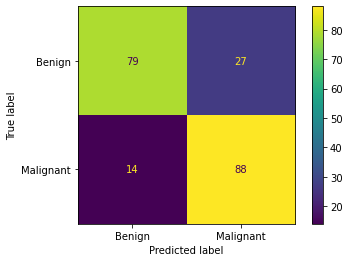

In [24]:
conf_mat = metrics.confusion_matrix(y_test, models["LogisticReg"].predict(x_test))
display = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=["Benign", "Malignant"])
display.plot()
plt.show()

Best recall is the SVC (poly).

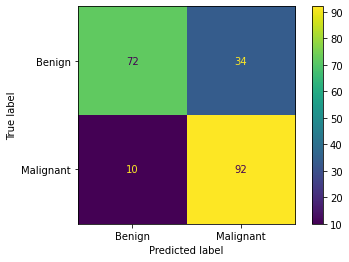

In [23]:
conf_mat = metrics.confusion_matrix(y_test, models["SVC (poly)"].predict(x_test))
display = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=["Benign", "Malignant"])
display.plot()
plt.show()